In [1]:
!pip install mediapipe opencv-python scikit-learn imbalanced-learn pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

2024-06-24 11:36:31.277381: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 11:36:31.462541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 11:36:32.243247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## Testando caminho

(-0.5, 47.5, 47.5, -0.5)

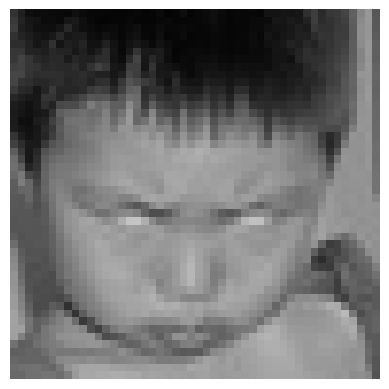

In [11]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

[ WARN:0@790.373] global loadsave.cpp:241 findDecoder imread_('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/PrivateTest_10131363.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

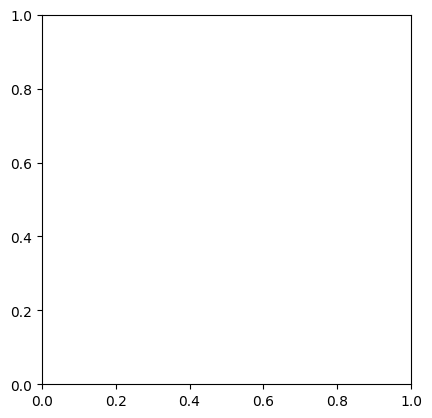

In [18]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/PrivateTest_10131363.jpg')
plt.imshow(image, 'binary')
plt.axis(False)

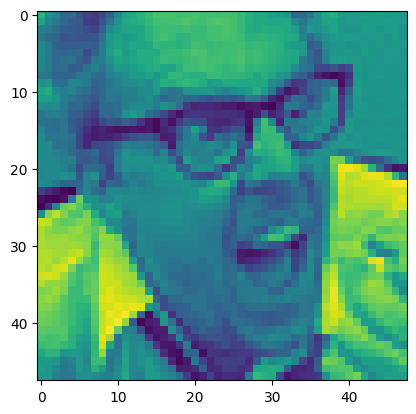

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

In [7]:
## Antes de remover as imagens

In [18]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test
There are 0 directories and 831 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/surprise
There are 0 directories and 1024 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/fear
There are 0 directories and 111 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/disgust
There are 0 directories and 1233 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/neutral
There are 0 directories and 1774 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/happy
There are 0 directories and 1247 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/sad
There are 0 directories and 9

In [7]:
## Remover imagens que não são rostos

In [34]:
face_detector = mp.solutions.face_detection.FaceDetection()
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection'

for dataset in ['train', 'test']:
    dataset_dir = os.path.join(data_dir, 'archive', dataset)
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            for image_path in image_paths:
                image = cv2.imread(image_path)
                results = face_detector.process(image)
                if not results.detections:
                    os.remove(image_path)
                    print(f"Removida imagem incorreta: {image_path}")

for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

I0000 00:00:1719194723.868474   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719194723.882620   95763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719194723.884447   95758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/jupyter-env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [46]:
## Iniciando

In [3]:
# Pontos da face
face_landmarks = [
    *mp.solutions.face_mesh.FACEMESH_LIPS,
    *mp.solutions.face_mesh.FACEMESH_LEFT_EYE,
    *mp.solutions.face_mesh.FACEMESH_LEFT_IRIS,
    *mp.solutions.face_mesh.FACEMESH_LEFT_EYEBROW,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_EYE,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS,
    *mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW,
    (21, 54), (103, 67), (109, 10), (338, 297), (332, 284), (251, 71), (68, 104), (69, 108), (151, 337), (299, 333), (298, 301), (9, 143), (111, 117), (118, 119), (120, 121), (128, 245), (214, 207), (205, 36), (142, 126), (217, 174), (372, 340), (346, 347), (348, 349), (350, 357), (465, 434), (427, 425), (266, 371), (355, 437), (399, 0)
]

# Caminho para o diretório train
train_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/'

# Lista para armazenar os caminhos e emoções
list_imgs = []

# Iterar sobre todas as classes no diretório de treinamento
trainpath = os.listdir(train_dir)
for cls in trainpath:
    print(f"Lendo diretório: {cls}")
    for img in os.listdir(train_dir + cls):
        list_imgs.append([cls + "/" + img, cls])

Lendo diretório: disgust
Lendo diretório: neutral
Lendo diretório: fear
Lendo diretório: sad
Lendo diretório: angry
Lendo diretório: happy
Lendo diretório: surprise


In [4]:
# DataFrame com os caminhos dos arquivos e emoções
df = pd.DataFrame(list_imgs, columns=['Filepath', 'emotion'])
df.head()

,Filepath,emotion
0,disgust/Training_8514439.jpg,disgust
1,disgust/Training_73989844.jpg,disgust
2,disgust/Training_71591976.jpg,disgust
3,disgust/Training_77025552.jpg,disgust
4,disgust/Training_14124662.jpg,disgust


In [5]:
# Verificar classes únicas e contagens
unique_classes, class_counts = df['emotion'].value_counts().index, df['emotion'].value_counts().values
print("Classes únicas:", unique_classes)
print("Contagem de amostras por classe:", class_counts)

face_detector = mp.solutions.face_detection.FaceDetection()

Classes únicas: Index(['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise', 'disgust'], dtype='object', name='emotion')
Contagem de amostras por classe: [7005 4852 4444 3763 3654 3043  385]


I0000 00:00:1719239815.368103   57204 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719239815.411071   57379 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1719239815.420366   57361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
def extract_landmarks(image):
    if len(image.shape) == 2 or image.shape[2] != 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image
    
    mp_face_mesh = mp.solutions.face_mesh.FaceMesh()

    results = mp_face_mesh.process(image_rgb)
    
    # Verificar se foram detectados landmarks
    if results.multi_face_landmarks:
        landmarks = np.array([[landmark.x, landmark.y] for landmark in results.multi_face_landmarks[0].landmark])
        return landmarks.reshape(-1)
    else:
        return None

# Função para carregar imagens e extrair landmarks em lotes
def process_images_in_batches(images):
    landmarks_list = []
    for image in images:
        landmarks = extract_landmarks(image)
        if landmarks is not None:
            landmarks_list.append(landmarks)
    return np.array(landmarks_list)

In [8]:
# Amostra de dados para treinamento e teste
sample_size = 100
X_train_sample = df['Filepath'].values[:sample_size]
y_train_sample = df['emotion'].values[:sample_size]

# Carregar e processar landmarks para treinamento e teste
X_train_images = [cv2.imread(train_dir + img) for img in X_train_sample]
X_train_landmarks = process_images_in_batches(X_train_images)

# Filtrar amostras com landmarks detectados
valid_samples = [i for i, landmarks in enumerate(X_train_landmarks) if landmarks is not None]
X_train_landmarks = [X_train_landmarks[i] for i in valid_samples]
y_train = [y_train_sample[i] for i in valid_samples]

# Agora, dividir em treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X_train_landmarks, y_train, test_size=0.2, random_state=42)

I0000 00:00:1719239971.439676   57204 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719239971.440782   59172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
W0000 00:00:1719239971.441985   59163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719239971.446792   59161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1719239971.455031   57204 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719239971.455924   59187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (TGL GT1)
W0000 00:00:1719239971.457450   59179 inference_feedback_manager.cc:114] Feedback 

In [9]:
# Inicializar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt', class_weight='balanced_subsample', random_state=42)
rf_model.fit(X_train, y_train)

# Previsão nas amostras de validação
y_pred_rf = rf_model.predict(X_valid)

# Calcular e exibir a acurácia
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f'Acurácia Random Forest: {accuracy_rf:.2f}')

# Gerar o relatório de classificação
report_rf = classification_report(y_valid, y_pred_rf)

# Exibir o relatório de classificação
print(report_rf)

Acurácia Random Forest: 1.00
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [10]:
# Normalizar os dados antes de treinar o modelo SVM
svm_model = make_pipeline(StandardScaler(), SVC(random_state=42))

# Treinar o modelo
svm_model.fit(X_train_landmarks, y_train)

# Prever com dados de validação
y_pred = svm_model.predict(X_valid)

# Avaliar o modelo
print("\nSupport Vector Classifier (SVC):")
print(classification_report(y_valid, y_pred))
print(f"Acurácia: {accuracy_score(y_valid, y_pred)}")

ValueError: Found input variables with inconsistent numbers of samples: [97, 77]